# Can you buy a good IMDB score?

### By Jarand Hornseth Pollestad , M Jahanzaib Anwar , Espen Sønneland

### In anaconda prompt: pip install easymoney

In [3]:
import numpy as np               # linear algebra
import pandas as pd              # data processing
import matplotlib                # plotting library
import seaborn as sns            # Another plotting library
import matplotlib.pyplot as plt

from easymoney.money import EasyPeasy               # Currency converter and inflation adjuster
from sklearn.preprocessing import StandardScaler    # Standardizing tool
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

                

%matplotlib inline               
%load_ext autoreload
%autoreload 2

Separate main dataset into two datasets sorting by dtypes. 

In [4]:
movies = pd.read_csv('movie_metadata.csv', sep = ',')

movies_str = movies.select_dtypes(include=['object'])
movies_num = movies.select_dtypes(include=['int64', 'float64'])


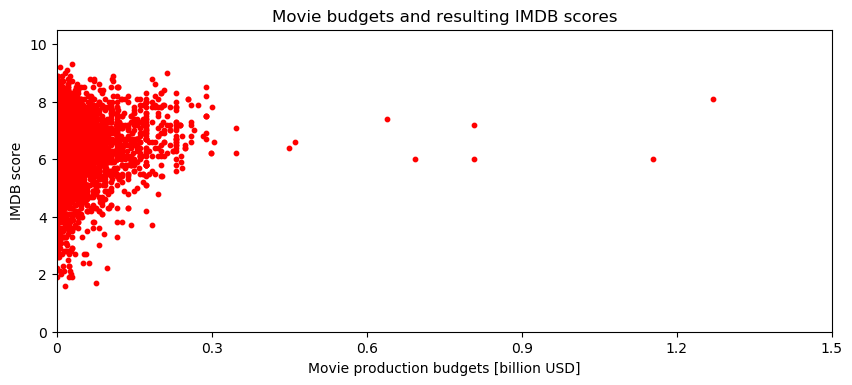

In [5]:
figure1 = plt.figure(figsize=(10, 4), dpi=100)
ax = figure1.add_subplot(111)

ax.scatter(movies_num['budget'], movies_num['imdb_score'], c='Red',s =10)
ax.set_title('Movie budgets and resulting IMDB scores')

ax.set_xlabel('Movie production budgets [billion USD]')
ax.set_ylabel('IMDB score')
ax.set_ylim(0, 10.5)
ax.set_xlim(0, 360000000)
ax.set_xticks(np.linspace(0, 1300000000, 6))
ax.set_xticklabels([0, 0.3, 0.6, 0.9, 1.2, 1.5])

plt.show()

#figure1.savefig('figure1.png', bbox_inches='tight', dpi=800, transparent=False)

The plot reveal some outliers that seems excessive.

In [6]:
movies_budget_sorted = movies.sort_values(['budget'], ascending=[0])
print(movies_budget_sorted[['country','movie_title','budget']].head())

          country         movie_title        budget
2988  South Korea           The Host   1.221550e+10
3859  South Korea     Lady Vengeance   4.200000e+09
3005      Hungary           Fateless   2.500000e+09
2323        Japan  Princess Mononoke   2.400000e+09
2334        Japan           Steamboy   2.127520e+09


The outliers are shown to be data for foreign movies. The budgets are given in foreign currencies. The next step is therefore to convert foreign currencies to USD. 

In [7]:
countries = movies.country.unique()
print(len(countries))

66


Identifying and converting the currencies of 66 unique countries to USD is too time-consuming, so we make the decision to focus on american made movies as these represent the majority. We utilize a package (easypeasy) to adjust production budgets and gross earnings for inflation. Movies from before 1960 are excluded because of lacking inflation data in the package.

In [8]:
movies_USA = movies_num[movies['country'] == 'USA']
movies_USA = movies_USA[(movies_USA['title_year'] >= 1960)]
movies_USA = movies_USA.dropna()

ep = EasyPeasy()

movies_USA['gross_adj'] = movies_USA.apply(lambda x: ep.normalize(x['gross'], region='USA', from_year=x['title_year'], to_year='latest', base_currency='USD'), axis=1)
movies_USA['budget_adj'] = movies_USA.apply(lambda x: ep.normalize(x['budget'], region='USA', from_year=x['title_year'], to_year='latest', base_currency='USD'), axis=1)

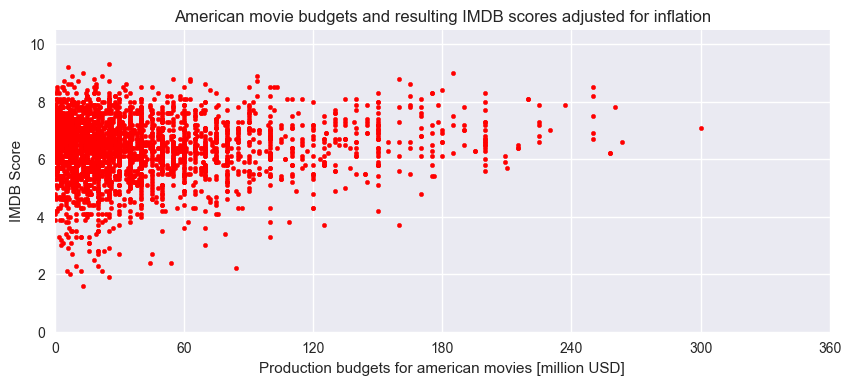

In [7]:
figure3 = plt.figure(figsize=(10, 4), dpi=100)
ax = figure3.add_subplot(111)

plt.scatter(movies_USA['budget'], movies_USA['imdb_score'], c='Red', s=10)
plt.title('American movie budgets and resulting IMDB scores adjusted for inflation')
plt.xlabel('Production budgets for american movies [million USD]')
plt.ylabel('IMDB Score')
plt.ylim(0, 10.5)
plt.xlim(0, 360000000)
ax.set_xticks(np.linspace(0, 360000000, 7))
ax.set_xticklabels([0, 60, 120, 180, 240, 300, 360])

plt.show()
#figure3.savefig('figure3.png', bbox_inches='tight', dpi=800, transparent=False)

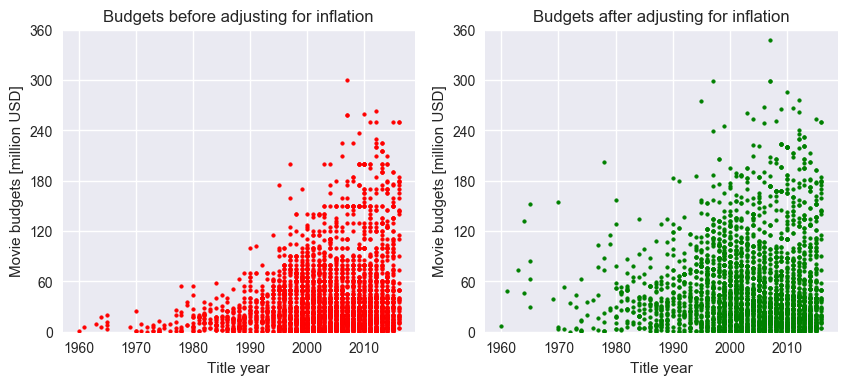

In [8]:
figure4 = plt.figure(figsize=(10, 4), dpi=100)

ax = figure4.add_subplot(121)
plt.scatter(movies_USA['title_year'], movies_USA['budget'], c='Red', s=7)
plt.title('Budgets before adjusting for inflation')
plt.ylabel('Movie budgets [million USD]')
plt.xlabel('Title year')
plt.ylim(0, 360000000)

ax.set_yticks(np.linspace(0, 360000000, 7))
ax.set_yticklabels([0, 60, 120, 180, 240, 300, 360])

ax = figure4.add_subplot(122)
plt.scatter(movies_USA['title_year'], movies_USA['budget_adj'], c='Green', s=7)
plt.title('Budgets after adjusting for inflation')
plt.ylabel('Movie budgets [million USD]')
plt.xlabel('Title year')
plt.ylim(0, 360000000)

ax.set_yticks(np.linspace(0, 360000000, 7))
ax.set_yticklabels([0, 60, 120, 180, 240, 300, 360])


plt.show()
#figure4.savefig('figure4.png', bbox_inches='tight', dpi=800, transparent=False)

We observe a positive correlation between increased budget and increased IMDB movie rating for SOME movies (up to a point), but due to the heavy cluster of datapoints where there seems to be no/little correlation we wish to further analyze the data we are using in order to find other major influencers on IMDB rating. 

### Princial Component Analysis (PCA)

In [9]:
movies_USA_PCA = movies_USA.drop(labels=['budget','gross'],axis=1)
column_names = movies_USA_PCA.columns.tolist()
column_names.insert(0, column_names.pop(column_names.index('imdb_score')))
movies_USA_PCA = movies_USA_PCA.reindex(columns= column_names)

X = movies_USA_PCA.iloc[:,1:16].values
y = movies_USA_PCA.iloc[:,0].values

In [10]:
X_std = StandardScaler().fit_transform(X)

In [11]:
pca = PCA(n_components=15).fit(X_std)
pca.explained_variance_ratio_

array([  2.96175418e-01,   1.40864766e-01,   1.05793149e-01,
         6.97731031e-02,   6.72834362e-02,   6.37074487e-02,
         5.60054153e-02,   4.59389829e-02,   4.27168742e-02,
         3.44986841e-02,   2.82932701e-02,   2.27564680e-02,
         1.51054688e-02,   1.09677897e-02,   1.19726154e-04])

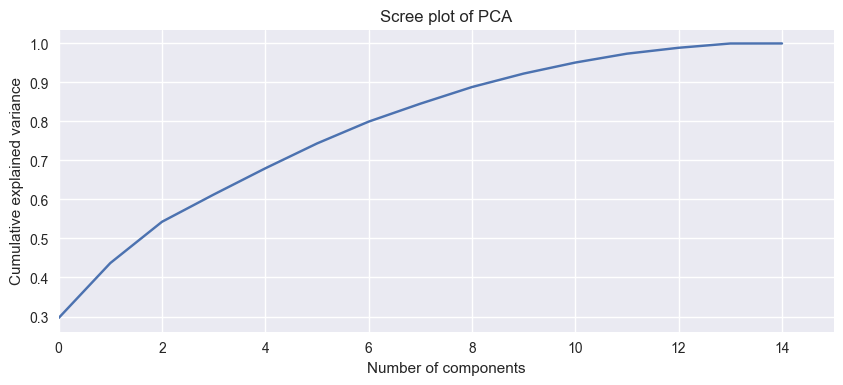

In [12]:
figure5 = plt.figure(figsize=(10, 4), dpi=100)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.plot((pca.explained_variance_ratio_))
plt.xlim(0,15,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Scree plot of PCA')
plt.show()
#figure5.savefig('figure5.png', bbox_inches='tight', dpi=800, transparent=False)

A large number of components is necessary to explain the variance in the data.

### To figure out what variables affects the IMDB score the most we use LASSO cross validation, and then create a model using RIDGE

In [13]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=10, max_iter=10000, n_alphas=1000)

movies_USA_reg = movies_USA.drop(labels=['budget','gross'],axis=1)

X = movies_USA_reg.values[:, movies_USA_reg.columns != 'imdb_score']
X_cols = movies_USA_reg.columns[movies_USA_reg.columns != 'imdb_score']
y = movies_USA_reg['imdb_score']

X -= X.mean(1, keepdims=True)
X /= X.std(1, keepdims=True)
y -= y.mean()
y /= y.std()

lasso.fit(X, y);

In [14]:
print('Optimal weight-focus: {} \n'.format(lasso.alpha_/(1+lasso.alpha_)))

for col, coef in zip(X_cols, lasso.coef_):
    print('{}: {:5f}'.format(col, coef))

Optimal weight-focus: 0.0023902855201150507 

num_critic_for_reviews: -0.000000
duration: -0.000000
director_facebook_likes: -0.000000
actor_3_facebook_likes: -0.000000
actor_1_facebook_likes: -0.000000
num_voted_users: 2.710326
cast_total_facebook_likes: -0.000000
facenumber_in_poster: -0.000000
num_user_for_reviews: -0.000000
title_year: -0.000000
actor_2_facebook_likes: -0.000000
aspect_ratio: -0.000000
movie_facebook_likes: -0.000000
gross_adj: 0.228637
budget_adj: 0.000000


Budget has a 0 coefficient, so the possible effect the budget has on the IMDB score can be explained through other variables.

As to not overfit the data, we make a linear model by using Ridge cross validation using the non-zero values from the Lasso model

In [15]:


ridge = RidgeCV(cv=10, alphas=np.logspace(-5, -1, 10), normalize=True)

X = movies_USA_reg.values[:, movies_USA_reg.columns != 'imdb_score'][:, lasso.coef_ != 0]
X_cols = movies_USA_reg.columns[movies_USA_reg.columns != 'imdb_score'][lasso.coef_ != 0]

y = movies_USA_reg['imdb_score']

X -= X.mean(1, keepdims=True)
X /= X.std(1, keepdims=True)
y -= y.mean()
y /= y.std()


ridge.fit(X, y)

for col, coef in zip(X_cols, ridge.coef_):
    print('{}: {:5f}'.format(col, coef))

num_voted_users: 0.061750
gross_adj: -0.061750


We hypothesized that some of the variables would better fit a non-linear regression. After lokking through some of the correlation plots we saw that Number of voted users seem to increase less as the IMDB rating increases.

In [1]:
figure7 = plt.figure(figsize=(10, 4), dpi=800)
sns.regplot('num_voted_users', 'imdb_score', data=movies_USA, scatter=True, fit_reg=True, color = 'Blue', marker='x',)
plt.xlabel('Number of user votes')
plt.ylabel('IMDB rating')
plt.title('Scatter plot with regression line')
plt.ylim(0, 11)
plt.show()
#figure7.savefig('figure7.png', bbox_inches='tight', dpi=800, transparent=False)

NameError: name 'plt' is not defined

To test our hypothesis we make a model using the square root of num_voted_users

In [17]:
movies_USA_root = movies_USA_reg.drop(labels=['num_voted_users'],axis=1).dropna()

num_voted_users_root = [i**(1/2) for i in movies_USA['num_voted_users']]
num_voted_users_root = np.asarray(num_voted_users_root)

num_voted_users_root = pd.Series(num_voted_users_root)
movies_USA_root['num_voted_users_root'] = num_voted_users_root.values

In [18]:
lasso_root = LassoCV(cv=10, max_iter=10000, n_alphas=1000)

X1 = movies_USA_root.values[:, movies_USA_root.columns != 'imdb_score']
X_cols = movies_USA_root.columns[movies_USA_root.columns != 'imdb_score']
y1 = movies_USA_root['imdb_score']

X1 -= X1.mean(0, keepdims=True)
X1 /= X1.std(0, keepdims=True)
y1 -= y1.mean()
y1 /= y1.std()

lasso.fit(X1, y1);

print('Optimal weight-focus: {} \n'.format(lasso.alpha_/(1+lasso.alpha_)))

for col, coef in zip(X_cols, lasso.coef_):
    print('{}: {:5f}'.format(col, coef))

Optimal weight-focus: 0.014589535422042948 

num_critic_for_reviews: 0.109759
duration: 0.232627
director_facebook_likes: 0.018775
actor_3_facebook_likes: -0.012643
actor_1_facebook_likes: 0.008805
cast_total_facebook_likes: 0.000000
facenumber_in_poster: -0.030442
num_user_for_reviews: -0.135964
title_year: -0.146678
actor_2_facebook_likes: 0.000000
aspect_ratio: 0.000000
movie_facebook_likes: 0.000000
gross_adj: -0.000000
budget_adj: -0.237305
num_voted_users_root: 0.590352


In [19]:
ridge_root = RidgeCV(cv=10, alphas=np.logspace(-5, -1, 10), normalize=True)

X1 = movies_USA_root.values[:, movies_USA_root.columns != 'imdb_score'][:, lasso.coef_ != 0]
X_cols = movies_USA_root.columns[movies_USA_root.columns != 'imdb_score'][lasso.coef_ != 0]

y1 = movies_USA_root['imdb_score']

X1 -= X1.mean(0, keepdims=True)
X1 /= X1.std(0, keepdims=True)
y1 -= y1.mean()
y1 /= y1.std()


ridge.fit(X1, y1)

for col, coef in zip(X_cols, ridge.coef_):
    print('{}: {:5f}'.format(col, coef))

num_critic_for_reviews: 0.154816
duration: 0.250671
director_facebook_likes: 0.026573
actor_3_facebook_likes: -0.032127
actor_1_facebook_likes: 0.025043
facenumber_in_poster: -0.044770
num_user_for_reviews: -0.204525
title_year: -0.176377
budget_adj: -0.265258
num_voted_users_root: 0.632886


Compare the cross validation scores with and without square rooted num_voted_users

In [20]:
from sklearn.model_selection import cross_val_score

CV_score = cross_val_score(ridge, X, y, cv=10, scoring='neg_mean_absolute_error').mean()
CV_score_root = cross_val_score(ridge_root, X1, y1, cv=10, scoring='neg_mean_absolute_error').mean()
print('CV_score=',CV_score,'and','CV_score_root=',CV_score_root)

CV_score= -0.774085179582 and CV_score_root= -0.582668440317


The model that includes rooted values of num_voted_users has less mean error when cross validated. This indicates a more precise model, and it is also a far more complex model (10 variables vs 2 variables). We still see that the number of voted users have a large impact on the model, but some less obvious variables also has an impact. This points us towards the conclusion that there is no clear recipie for a high rated movie.

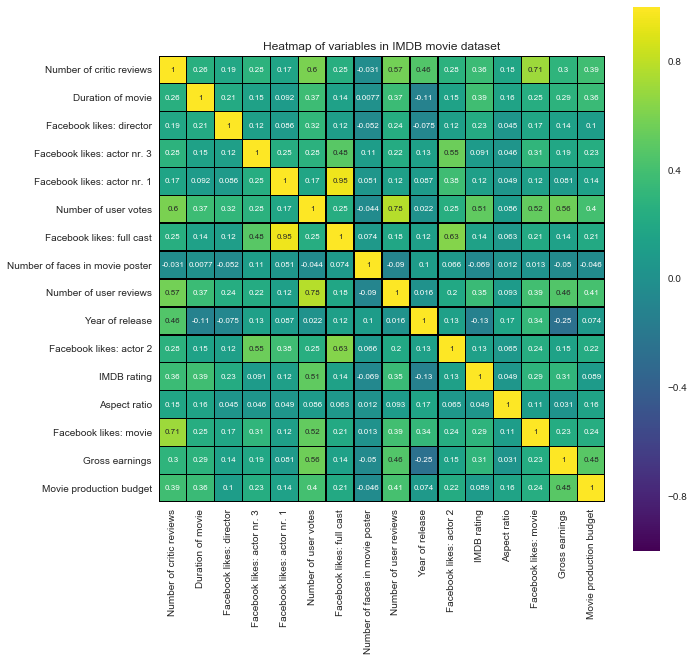

In [21]:
movies_USA_heat = movies_USA.drop(labels=['budget','gross'],axis=1)

figure_heatmap = plt.figure(figsize=(10, 10))
ax = figure_heatmap.add_subplot(111)

_curr_fontsize = plt.rcParams['font.size']
plt.rcParams.update({'font.size': 8})

sns.heatmap(movies_USA_heat.astype(float).corr(),linewidths=0.5,linecolor='black',cmap='viridis', square=True, annot=True)
plt.title('Heatmap of variables in IMDB movie dataset')

ax.set_yticklabels(('Movie production budget','Gross earnings','Facebook likes: movie',
                    'Aspect ratio','IMDB rating','Facebook likes: actor 2','Year of release','Number of user reviews',
                    'Number of faces in movie poster','Facebook likes: full cast','Number of user votes', 
                    'Facebook likes: actor nr. 1', 'Facebook likes: actor nr. 3', 'Facebook likes: director', 
                    'Duration of movie','Number of critic reviews'), 
                   rotation=0)


ax.set_xticklabels(('Number of critic reviews', 'Duration of movie', 'Facebook likes: director', 'Facebook likes: actor nr. 3', 
                    'Facebook likes: actor nr. 1', 'Number of user votes', 'Facebook likes: full cast', 
                    'Number of faces in movie poster', 'Number of user reviews', 'Year of release', 
                    'Facebook likes: actor 2', 'IMDB rating', 'Aspect ratio', 'Facebook likes: movie', 'Gross earnings', 
                    'Movie production budget'), 
                   rotation=90)



plt.rcParams.update({'font.size': _curr_fontsize})
figure_heatmap.savefig('figure_heatmap.png', bbox_inches='tight', dpi=1200, transparent=False)

## Conclutions

IMDB score can not be predicted precisely from this dataset. The best linear model is complex, and a lot of principal components are needed to explain the variance. This means we don't have the right variables, or that there is no simple combination of analyzed variables which can predict the IMDB score. There are some correlations in the heatmap, but from the multivariance analysis we know that none are very strong alone.

We do see some trends. Popularity has a positive effect on IMDB score, movies have become more costly,and if a movie has a high budget it is less likely to have a low IMDB score.

Can you buy a good IMDB score? No, you're not garanteed a high score if you spend a lot of money, but money doesn't hurt your odds. 

### Data sources

- https://www.kaggle.com/deepmatrix/imdb-5000-movie-dataset
- https://pypi.python.org/pypi/easymoney/1.5.0
       - Consumer price index (https://data.worldbank.org/indicator/FP.CPI.TOTL)
       - Euro foreign exchange reference rates (https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/index.en.html)
        